In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 40.8 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Mecab
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

## Download the data

In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 30.1MB/s]


In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df = df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SID     200000 non-null  int64 
 1   원문      200000 non-null  object
 2   번역문     200000 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


#Configuration

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_DIM = 256
EMBEDDING_DIM = 64
NUM_SAMPLES = 200000

# preprocessing

In [ ]:
def preprocess_sentence(sent):

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # 가-힣, a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z가-힣!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [ ]:
# dataset 
kor_corpus, eng_corpus = [], []
for i, row in df.iterrows():
    # source 데이터와 target 데이터 분리
    tar_line, src_line = row['원문'], row['번역문']
    
    kor_corpus.append(tar_line)
    eng_corpus.append(src_line)

print(len(kor_corpus), kor_corpus[:10])
print(len(eng_corpus), eng_corpus[:10])

200000 ["'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다.", '씨티은행에서 일하세요?', '푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.', '11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.', '6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.', 'F/W 겐조타이거 키즈와 그리고 이번에 주문한 키즈 중 부족한 수량에 대한 환불입니다.', '강아지들과 내 사진을 보낼게.', '그 수익금 중 일부를 위안부 할머니들을 위해 쓰고 그들을 위해 여러 가지 캠페인을 벌이고 있습니다.', '그들은 내가 잘하는 것을 바탕으로 별명을 사용하고 있기 때문에 나는 사람들이 치타라고 불러주면 기분이 좋아.', '그러므로 실제로 컴퓨터 프로그램을 만든 사람이 프로그램에 대한 저작자가 돼요.']
200000 ["Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible.", 'Do you work at a City bank?', "PURITO's bestseller, which recorded 4th rough -cuts by words of mouth from abroad.", 'In Chapter 11 Jesus called Lazarus from the tomb and raised him from the dead.', 'I would feel grateful to know how many stocks will be secured of size 6.5, 7, and 8.', '18fw Kenzo Tiger Kids, and refund for lacking quantity of Kids which was ordered this time.', "And I'll send you a picture of me and 

In [ ]:
okt=Okt()

In [ ]:
def load_preprocessed_data(kor_corpus, eng_corpus):
    encoder_input, decoder_input, decoder_output = [], [], []

    for i, (src_line, tar_line) in enumerate(zip(kor_corpus, eng_corpus)):
        # source 데이터 전처리
        src_line = okt.morphs(src_line)
        src_line = [token for token in src_line]

        # target 데이터 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line) # 클리닝 
        decoder_input.append(tar_line_in) # 클리닝 + sos 
        decoder_output.append(tar_line_out) # 클리닝 + eos 

        if i == NUM_SAMPLES - 1: # 0~29999 == 30000 이기 때문에
            break
                    
    return encoder_input, decoder_input, decoder_output

In [ ]:
# 전처리 테스트
ko_sent = u"저녁 먹었어?"
en_sent = u"Have you had dinner?"

print('전처리 전 한국어 문장 :', ko_sent)
print('전처리 후 한국어 문장 :',preprocess_sentence(ko_sent))
print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :', preprocess_sentence(en_sent))

전처리 전 한국어 문장 : 저녁 먹었어?
전처리 후 한국어 문장 : 저녁 먹었어 ?
전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : Have you had dinner ?


In [ ]:
sents_kor_in, sents_en_in, sents_en_out = load_preprocessed_data(kor_corpus, eng_corpus)

In [ ]:
print('인코더의 입력 :',sents_kor_in[-5:]) # 한국어 클리닝
print('디코더의 입력 :',sents_en_in[-5:]) # 영어 decoder input
print('디코더의 레이블 :',sents_en_out[-5:]) # 영어 decoder output # 't를 어떻게 해야할까..

인코더의 입력 : [['나', '는', '먼저', '청소기', '로', '바닥', '을', '밀었어요', '.'], ['나', '는', '먼저', '팀', '과제', '를', '하고', '놀러', '갔어요', '.'], ['나', '는', '비', '같은', '멋진', '연예인', '을', '좋아해요', '.'], ['나', '는', '멋진', '자연', '경치', '를', '보고', '눈물', '을', '흘렸어', '.'], ['나', '는', '멋진', '중학교', '생활', '을', '기대합니다', '.']]
디코더의 입력 : [['<sos>', 'First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.'], ['<sos>', 'I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.'], ['<sos>', 'I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.'], ['<sos>', 'I', 'cried', 'seeing', 'the', 'amazing', 'scenery', '.'], ['<sos>', 'I', 'look', 'forward', 'to', 'a', 'great', 'middle', 'school', 'experience', '.']]
디코더의 레이블 : [['First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.', '<eos>'], ['I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.', '<eos>'], ['I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.', '<eos>'], ['I', 'cried', 'seeing', 'the', 'amazing'

In [ ]:
# 한국어 (encoder)

tokenizer_enc = Tokenizer(filters='', lower=False)
tokenizer_enc.fit_on_texts(sents_kor_in)
# print(sents_kor_in)
# 인코더 데이터

encoder_input = tokenizer_enc.texts_to_sequences(sents_kor_in)

In [ ]:
print(encoder_input)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 영어 (decoder)

tokenizer_dec = Tokenizer(filters = '', lower = True) # filters = 걸러낼 문자 리스트
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)


decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_output = tokenizer_dec.texts_to_sequences(sents_en_out)

In [ ]:
print(encoder_input[-5:])
print(decoder_input[-5:])
print(decoder_output[-5:])

[[10, 4, 241, 9293, 26, 1747, 2, 73168, 1], [10, 4, 241, 326, 1165, 7, 30, 1194, 906, 1], [10, 4, 357, 168, 798, 2356, 2, 579, 1], [10, 4, 798, 734, 3008, 7, 141, 2706, 2, 32988, 1], [10, 4, 798, 1609, 384, 2, 2659, 1]]
[[3, 90, 11, 65, 5, 35241, 2, 496, 1], [3, 5, 111, 2, 293, 2233, 90, 10, 153, 79, 6, 283, 1], [3, 5, 39, 967, 8064, 39, 948, 1], [3, 5, 2761, 879, 2, 1478, 1864, 1], [3, 5, 191, 614, 6, 7, 209, 623, 114, 296, 1]]
[[90, 11, 65, 5, 35241, 2, 496, 1, 4], [5, 111, 2, 293, 2233, 90, 10, 153, 79, 6, 283, 1, 4], [5, 39, 967, 8064, 39, 948, 1, 4], [5, 2761, 879, 2, 1478, 1864, 1, 4], [5, 191, 614, 6, 7, 209, 623, 114, 296, 1, 4]]


In [ ]:
# 잘 나오는지 확인
tokenizer_enc.sequences_to_texts(encoder_input[0:1])

["' Bible Coloring ' 은 성경 의 아름다운 이야기 를 체험 할 수 있는 컬러링 앱 입니다 ."]

In [ ]:
print(tokenizer_enc.word_index) # 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환. 이때 반환 시 자동으로 소문자로 변환되어 들어간다.
print(tokenizer_dec.word_index)

{'.': 1, '을': 2, '이': 3, '는': 4, '에': 5, '가': 6, '를': 7, '의': 8, '은': 9, '나': 10, '?': 11, '것': 12, ',': 13, '당신': 14, '그': 15, '들': 16, '우리': 17, '수': 18, '에서': 19, '으로': 20, '내': 21, '저': 22, '입니다': 23, '할': 24, '한': 25, '로': 26, '과': 27, '해': 28, '하는': 29, '하고': 30, '합니다': 31, '있습니다': 32, '에게': 33, '와': 34, '도': 35, '적': 36, '사람': 37, '요': 38, '이에요': 39, '생각': 40, '너': 41, '있는': 42, '때': 43, '오늘': 44, '고': 45, '잘': 46, '거': 47, '인': 48, '말': 49, '그녀': 50, '했어요': 51, '때문': 52, '일': 53, '더': 54, '있어요': 55, '못': 56, '친구': 57, '안': 58, '네': 59, '시간': 60, '했습니다': 61, '에는': 62, '하지': 63, '한국': 64, '위해': 65, '서': 66, '제품': 67, '제': 68, '사용': 69, '곳': 70, '해요': 71, '된': 72, '게': 73, '많이': 74, '중': 75, '만': 76, '있어': 77, '가지': 78, '까지': 79, '많은': 80, '그것': 81, '집': 82, '해서': 83, '다': 84, '대해': 85, '난': 86, '확인': 87, '해야': 88, '다른': 89, '너무': 90, '예요': 91, '하여': 92, '알': 93, '가장': 94, '지금': 95, '주': 96, '전': 97, '사진': 98, '후': 99, '그리고': 100, '다음': 101, '좋은': 102, '함께': 103, '위': 104, '문제': 1

In [ ]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE  =len(tokenizer_dec.word_index) + 1

print(f"한국어 단어 집합의 크기 : {SRC_VOCAB_SIZE}, 영어 단어 집합의 크기 : {TAR_VOCAB_SIZE}")

한국어 단어 집합의 크기 : 73169, 영어 단어 집합의 크기 : 35242


In [ ]:
encoder_input = pad_sequences(encoder_input, padding = "post")
decoder_input = pad_sequences(decoder_input, padding = "post")
decoder_output = pad_sequences(decoder_output, padding  = 'post')

In [ ]:
decoder_output

array([[ 2790,  5718,     9, ...,     0,     0,     0],
       [   35,     8,    75, ...,     0,     0,     0],
       [ 6335,    23, 15828, ...,     0,     0,     0],
       ...,
       [    5,    39,   967, ...,     0,     0,     0],
       [    5,  2761,   879, ...,     0,     0,     0],
       [    5,   191,   614, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_output.shape)

인코더의 입력의 크기(shape) : (200000, 48)
디코더의 입력의 크기(shape) : (200000, 52)
디코더의 레이블의 크기(shape) : (200000, 52)


In [ ]:
# 변수 저장
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1] # 15, 9, 9

In [ ]:
src2idx = tokenizer_enc.word_index  # word : idx
idx2src = tokenizer_enc.index_word  # idx : word
tar2idx = tokenizer_dec.word_index # word : idx
idx2tar = tokenizer_dec.index_word # idx : word

In [ ]:
print(src2idx)
print(idx2src)
print(tar2idx)
print(idx2tar)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 랜덤 인덱스 생성 
indices = np.arange(encoder_input.shape[0]) # np.arange(3) => [0,1,2] / encoder_input = 33000
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

# 랜덤하게 섞기
encoder_input = encoder_input[indices] # 문장 단위로 뽑힘 ex) 1번 문장, 5번 문장
decoder_input = decoder_input[indices]
decoder_output = decoder_output[indices]

print()
print(decoder_input[indices[0]])
print(decoder_output[indices[0]]) 

랜덤 시퀀스 : [ 94958 196704  43652 ...  62500 134679 124063]

[   3   64    9    2   81  139 2827  116  141   23   81  851    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  64    9    2   81  139 2827  116  141   23   81  851    1    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
encoder_input.shape,decoder_input.shape, decoder_output.shape

((200000, 48), (200000, 52), (200000, 52))

In [ ]:
encoder_input[9999]

array([   41,  1129,  1425,  1402,    19,    10, 19085,    11,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [ ]:
decoder_input[9999]

array([   3,  111,    8,  107,   29,   36,    2,  377,   23, 3440,   14,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_output[9999]

array([ 111,    8,  107,   29,   36,    2,  377,   23, 3440,   14,    4,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
n_of_val = int(NUM_SAMPLES*0.1) # 1/10
# train data
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val] 
decoder_output_train = decoder_output[:-n_of_val] 

# test data
encoder_input_test = encoder_input[-n_of_val:] 
decoder_input_test = decoder_input[-n_of_val:] 
decoder_output_test = decoder_output[-n_of_val:] 

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_output_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_output_test.shape)

훈련 source 데이터의 크기 : (180000, 48)
훈련 target 데이터의 크기 : (180000, 52)
훈련 target 레이블의 크기 : (180000, 52)
테스트 source 데이터의 크기 : (20000, 48)
테스트 target 데이터의 크기 : (20000, 52)
테스트 target 레이블의 크기 : (20000, 52)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, concatenate, Attention

In [ ]:
# 인코더 (Train)

## 층 
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM) # Embedding(input_dim, output_dim) input_dim = 들어가는 숫자의 최댓값, output_dim = 결과값이 몇 개로 나올지 정하기
encoder_lstm = LSTM(HIDDEN_DIM, return_sequences = True, return_state = True) # 상태값 리턴을 위해 return_state는 True # HIDDEN_DIM = 하이퍼 파라미터


## input -> output 
encoder_inputs = Input(shape=(None, ))
enc_emb = enc_emb_layer(encoder_inputs)
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 리스트로 저장

In [ ]:
encoder_outputs.shape

TensorShape([None, None, 256])

In [ ]:
# 디코더 (Train)
decoder_inputs = Input(shape=(None, ))

#상태값 리턴을 위해 lstm layer return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True)
attention_layer = Attention(name='attention_layer')
## input -> output 
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용

dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

# Attention layer
attention_out = attention_layer([decoder_outputs, encoder_outputs])

# Concatenating the decoder output with attention output
rnn_output = concatenate([decoder_outputs, attention_out], name = "rnn_output")

# Dense layer
# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
dense_layer0 = Dense(HIDDEN_DIM, activation='tanh', name='dense_layer0')
dense_layer1 = dense_layer0(rnn_output)

decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')
decoder_outputs = decoder_dense(dense_layer1)

In [ ]:
decoder_outputs.shape

TensorShape([None, None, 35242])

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # input 과 output 넣기

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'], )

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     4682816     ['input_6[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    9021952     ['input_7[0][0]']                
                                                                                            

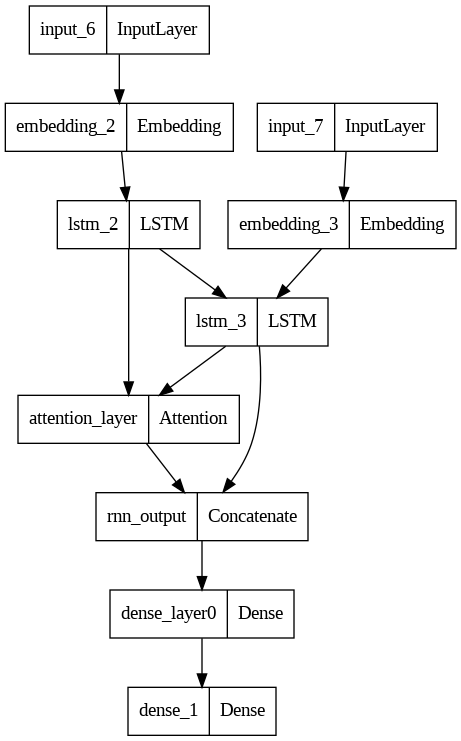

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(x = [encoder_input_train, decoder_input_train], 
          y = decoder_output_train, 
          validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), # 비율을 주지 않는 이유?
          batch_size = BATCH_SIZE, 
          callbacks = [earlystopping],
          verbose = 1,
          epochs = EPOCHS
          )

Epoch 1/100
2813/2813 [==============================] - 142s 49ms/step - loss: 1.3894 - acc: 0.8068 - val_loss: 1.1831 - val_acc: 0.8229
Epoch 2/100
2813/2813 [==============================] - 103s 37ms/step - loss: 1.1042 - acc: 0.8279 - val_loss: 1.0235 - val_acc: 0.8345
Epoch 3/100
2813/2813 [==============================] - 100s 35ms/step - loss: 0.9517 - acc: 0.8397 - val_loss: 0.9215 - val_acc: 0.8434
Epoch 4/100
2813/2813 [==============================] - 99s 35ms/step - loss: 0.8373 - acc: 0.8497 - val_loss: 0.8533 - val_acc: 0.8511
Epoch 5/100
2813/2813 [==============================] - 99s 35ms/step - loss: 0.7464 - acc: 0.8588 - val_loss: 0.8144 - val_acc: 0.8560
Epoch 6/100
2813/2813 [==============================] - 99s 35ms/step - loss: 0.6731 - acc: 0.8665 - val_loss: 0.7926 - val_acc: 0.8589
Epoch 7/100
2813/2813 [==============================] - 99s 35ms/step - loss: 0.6108 - acc: 0.8738 - val_loss: 0.7836 - val_acc: 0.8608
Epoch 8/100
2813/2813 [===============

# INFERENCE

In [ ]:
# 인코더 모델 정의 - 훈련과 동일
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states]) # model(inputs, outputs)

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          4682816   
                                                                 
 lstm_2 (LSTM)               [(None, None, 256),       328704    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 5,011,520
Trainable params: 5,011,520
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# The decoder model, to generate the French tokens (in integer form)
# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,)) # hidden state
decoder_input_c = Input(shape=(HIDDEN_DIM,)) # cell state
attention_state = Input(shape=(None,None,))

decoder_states_inputs = [decoder_input_h, decoder_input_c] # hidden state와 cell state를 input 값으로 들어감

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# Attention layer

attention = attention_layer([x,attention_state])

# Concatenating the decoder output with attention output
rnnoutput = concatenate([x, attention], name = "rnn_output")

# Dense layer
# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
g0= dense_layer0(rnnoutput)
dense_output = decoder_dense(g0)

decoder_model = Model([decoder_inputs] +decoder_states_inputs + [attention_state], 
    [dense_output] + decoder_states2)
# 수정된 디코더 / 디코더 모델은 이전에 정의한 decoder_inputs와 decoder_states_inputs을 입력으로 받고, 디코딩된 결과와 상태 값을 출력

decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    9021952     ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

In [ ]:
def translate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # 입력 문장 토큰 -> 라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    # 입력 문장 라벨링 -> 패딩 
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    encoder_outputs, states_value = encoder_model.predict(enc_input) # 마지막 시점의 은닉 상태와 셀 상태를 리턴

    # Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar2idx['<sos>'] 

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value + [encoder_outputs], verbose=0)
        
        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :]) # argmax = 최댓값의 인덱스를 찾고 싶을 때
        result_word = idx2tar[result_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+result_word

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (result_word == '<eos>' or
            len(decoded_sentence) > 50):
            stop_condition = True



        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = result_token_index
        # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
        states_value = [h, c]

    return decoded_sentence.strip(' <eos>')

In [ ]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:] 

In [ ]:
n_samples = 5
np.random.choice(train_idx, n_samples)

array([ 47253, 181721, 153821,  97822, 140451])

In [ ]:
# train data - translate
n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = kor_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence) 
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 1s 511ms/step
입력문장 : 여기는 일산에서 유명한 곳인 라페스타입니다.
정답문장 : This is a famous attraction in Il-san, La Festa.
번역문장 : it s famous for it .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : 고기를 구울 때에는 참나무를 사용해요.
정답문장 : They use oak trees when roasting meat.
번역문장 : it s been a meter .
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : 손잡이에 단추가 없어서 불편해요.
정답문장 : It is uncomfortable because there is no button on handle.
번역문장 : i m not enough for you .
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : 나는 시간이 날 때마다 여행을 다닐 것입니다.
정답문장 : I will travel whenever I have time.
번역문장 : i will be back to the end .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : 예전 건 좀 복잡했는데 이번 건 정말 좋아요.
정답문장 : The old one used to be a bit complicated bu

In [ ]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = kor_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence) 
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 22ms/step
입력문장 : 나는 제주도에서 깨끗한 바다와 많은 유채꽃을 볼 수 있었어요.
정답문장 : I could see the clear ocean and plenty of canola flowers in Jeju island.
번역문장 : it was a good looking for a new couple .
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : 숟가락이나 젓가락, 포크와 같은 식기는 해수욕장 앞 상점에서 살 수 있습니다.
정답문장 : Cutlery is available for purchase from the store at the beach.
번역문장 : we can live in the ocean of the river .
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : 내년에 친구와 함께 프랑스에 가려고 생각하고 있습니다.
정답문장 : I was thinking of visiting France next year with a friend.
번역문장 : i m going to go with you .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : 그녀는 동생을 만나러 가다가 그를 만났어.
정답문장 : Going to see her sister, She came across him.
번역문장 : i met him at the earliest .
--------------------------------------------

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
